In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os.path
import zipfile
import skimage.io
import skimage.segmentation
from skimage.morphology import square
import skimage.morphology

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Read metadata

In [3]:
df = pd.read_csv("/storage/data/DSB2018/metadata/submissions.csv")
df = df.dropna()
df[df["team"].isin(["[ods.ai] topcoders", "jacobkie", "Deep Retina"])]

,filename,id,score,team
0,submission_1.csv,7193229,0.631646,[ods.ai] topcoders
1,submission_0.csv,7193223,0.624104,[ods.ai] topcoders
163,stage2_sub_006_20180407T02144.csv,7199325,0.577395,Deep Retina
164,stage2_sub_003b_20180409T01434.csv,7199273,0.614046,Deep Retina
248,sub-scale3.csv,7215993,0.614730,jacobkie
249,sub-scale2.csv,7215877,0.591552,jacobkie


# Auxiliary functions

In [4]:
from skimage.color import label2rgb

def replace_rgb_color(image, find, replace):
    mask = np.ones_like(image[:,:,0]).astype(np.bool)
    
    for k in range(3):
        mask *= (image[:,:,k] == find[k])
        
    for k in range(3):
        image[mask, k] = replace[k]
        
    return image

def get_segmentation(path, gtO, gtI, gtB):
    # read segmentation
    sm = skimage.io.imread(path)
    sm = skimage.segmentation.find_boundaries(sm, mode="thick")
    
    # Create composite image
    comp = np.zeros((gtB.shape[0], gtB.shape[1], 3))
    comp[:,:,0] = skimage.morphology.dilation(sm, square(2))
    comp[:,:,2] = skimage.morphology.dilation(gtB, square(2))
    
    # Remap color of correctly predicted pixels
    comp = replace_rgb_color(comp, [0,0,0], [0.8, 0.8, 0.8])
    comp = replace_rgb_color(comp, [1,0,1], [0.99, 0.99, 0.99])#[0/255., 150/255., 0/255.])
    comp = replace_rgb_color(comp, [0,0,1], [0, 0.5, 1])#[81/255., 81/255., 255/255.])
    comp = replace_rgb_color(comp, [1,0,0], [1, 0, 0])#[255/255., 81/255., 84/255.])
    
    R = gtI.copy()
    for k in range(3):
        mask = comp[:,:,k] > 0
        R[mask, k] = comp[mask,k]
    
    return comp

def center_crop(img):
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
    # Crop center of image
    r = img.shape[0]
    c = img.shape[1]
    d = int( (r - c)/2 )
    
    e = 50
    if d > 0:
        img = img[d+e:-d-e,e:-e,:]
    elif d < 0:
        img = img[e:-e,-d+e:d-e,:]
        
    return img
   

# Show segmentations of top-3 competitors

33d6d8e9d74f9da9679000a6cf551fffe4ad45af7d9679e199c5c4bd2d1e0741.png
f22874c8fac3c7c39297796cf8e03f1b5c18a1a2497973ae9338f7f7dd46d36b.png
522ce42064ddfc4a0e6469ba6384b3b052da41ba26ce59f06560f9204e86bee8.png
b45aa69520b8bba2bb3e07666625b293a3d17133a75c00c5102ca0b06d3c290e.png
3c20f44a4d4f215ff42b752e31444d674a20de481fa44137aeb3893edbffb08d.png
5


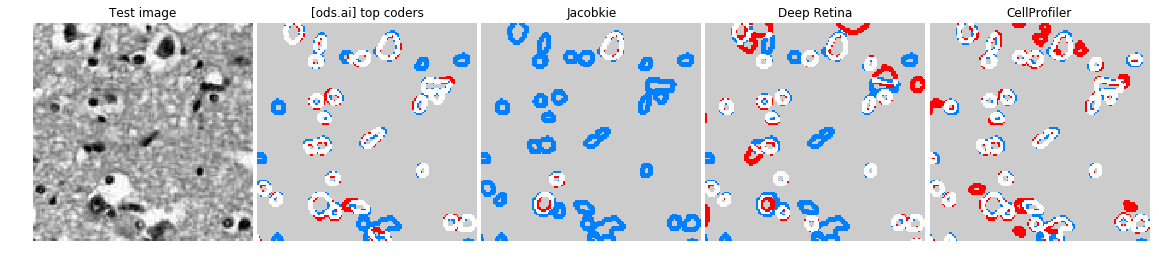

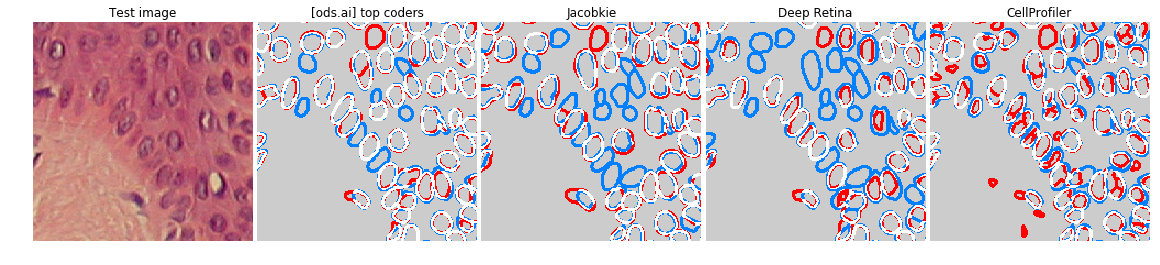

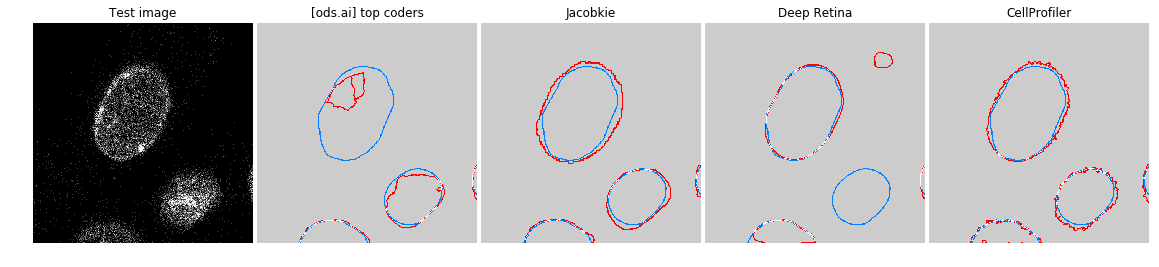

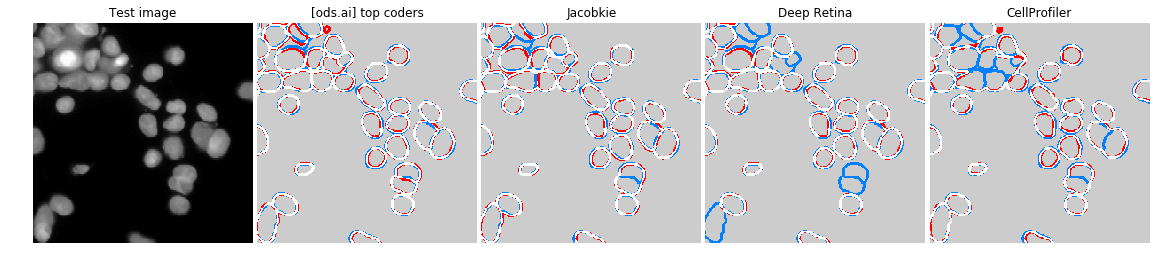

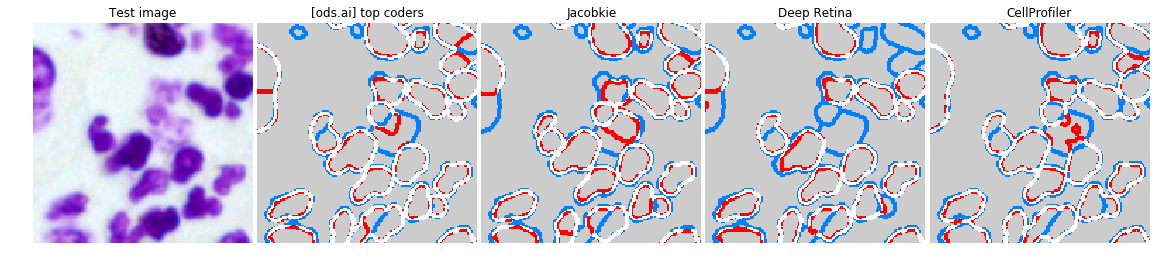

In [5]:
count = 0
path = "/storage/data/DSB2018/"
submissions = ["7193229", "7215993", "7199273"]
titles = ["[ods.ai] top coders", "Jacobkie", "Deep Retina"]

selected = [
    "33d6d8e9d74f9da9679000a6cf551fffe4ad45af7d9679e199c5c4bd2d1e0741.png", # -18 
    "f22874c8fac3c7c39297796cf8e03f1b5c18a1a2497973ae9338f7f7dd46d36b.png", # 14
    "522ce42064ddfc4a0e6469ba6384b3b052da41ba26ce59f06560f9204e86bee8.png", # 36 
    "b45aa69520b8bba2bb3e07666625b293a3d17133a75c00c5102ca0b06d3c290e.png", # 45
    "3c20f44a4d4f215ff42b752e31444d674a20de481fa44137aeb3893edbffb08d.png", # 62
]

for f in selected: # os.listdir(path + "phase-2-imgs/"):
    print(f)
    im = skimage.io.imread(path + "phase-2-imgs/" + f)
    gtO = skimage.io.imread(path + "phase-2-gt/" + f)
    gtI = label2rgb(gtO, image=im, bg_label=0, alpha=0.3)
    gtB = skimage.segmentation.find_boundaries(gtO, mode="thick")
    comp = [get_segmentation(path + "phase-2-predictions/" + s + "-" + f, gtO, gtI, gtB) for s in submissions]
    comp += [get_segmentation(path + "CP_segmentations/all/cellprofiler-" + f.replace(".png", ".tiff"), gtO, gtI, gtB)]
    comp = [center_crop(c) for c in comp]
    
    fig, ax = plt.subplots(1,5, figsize=(20,5))
    ax[0].imshow(center_crop(im)/np.max(im))
    ax[0].axis("off")
    ax[0].set_title("Test image")
    for i in range(len(submissions)):
        ax[i+1].imshow(comp[i])
        ax[i+1].axis("off")
        ax[i+1].set_title(titles[i])
    ax[i+2].imshow(comp[i+1])
    ax[i+2].axis("off")
    ax[i+2].set_title("CellProfiler")
    count += 1
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    
print(count)